# Load data

In [1]:
import json
import torch
# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)


In [2]:
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]

# Check the number of samples in each subset
len(train_sentences), len(val_sentences), len(test_sentences), len(oos_train_sentences), len(oos_val_sentences), len(oos_test_sentences)


(15000, 3000, 4500, 100, 100, 1000)

In [3]:
unique_intents = list(set(train_labels)) 
unique_intents[:5]

['application_status', 'change_language', 'goodbye', 'todo_list', 'recipe']

In [4]:
from sentence_transformers import SentenceTransformer, models

In [5]:
word_embedding_model = models.Transformer('distilroberta-base')

In [6]:
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode="max")

In [7]:
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [8]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': True, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [9]:
train_embeddings = model.encode(train_sentences)
val_embeddings = model.encode(val_sentences)
test_embeddings = model.encode(test_sentences)
oos_train_embeddings = model.encode(oos_train_sentences)
oos_val_embeddings = model.encode(oos_val_sentences)
oos_test_embeddings = model.encode(oos_test_sentences)

In [299]:
oos_val_embeddings

array([[ 0.15114488,  0.18033633,  0.14151229, ..., -0.03977443,
         0.15054666,  0.36607608],
       [ 0.15191764,  0.07760993,  0.2230569 , ..., -0.04667495,
         0.16884641,  0.3425523 ],
       [ 0.1868238 ,  0.06844131,  0.06588679, ...,  0.16693448,
         0.04852508,  0.12702547],
       ...,
       [ 0.12925576,  0.05809332,  0.15430582, ...,  0.39483568,
         0.10025732,  0.08343878],
       [ 0.15061258,  0.08064594,  0.1644352 , ...,  0.12821643,
         0.13164815,  0.04550483],
       [ 0.20929474,  0.0883693 ,  0.02329976, ...,  0.33118302,
         0.1077889 ,  0.06804351]], dtype=float32)

In [338]:
oos_val_embeddings

array([[ 0.15114488,  0.18033633,  0.14151229, ..., -0.03977443,
         0.15054666,  0.36607608],
       [ 0.15191764,  0.07760993,  0.2230569 , ..., -0.04667495,
         0.16884641,  0.3425523 ],
       [ 0.1868238 ,  0.06844131,  0.06588679, ...,  0.16693448,
         0.04852508,  0.12702547],
       ...,
       [ 0.12925576,  0.05809332,  0.15430582, ...,  0.39483568,
         0.10025732,  0.08343878],
       [ 0.15061258,  0.08064594,  0.1644352 , ...,  0.12821643,
         0.13164815,  0.04550483],
       [ 0.20929474,  0.0883693 ,  0.02329976, ...,  0.33118302,
         0.1077889 ,  0.06804351]], dtype=float32)

In [326]:
train_embeddings.shape

(15000, 768)

In [327]:
import numpy as np
from scipy.linalg import inv

In [328]:
intent_means = {}

for intent in unique_intents:
    indices = [i for i, label in enumerate(train_labels) if label == intent]
    intent_embeddings = train_embeddings[indices]
    intent_mean = np.mean(intent_embeddings, axis=0)
    intent_means[intent] = intent_mean

In [329]:
len(intent_means)

150

In [330]:
intent_means["damaged_card"].shape

(768,)

In [331]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

In [332]:
covariance = np.cov(train_embeddings, rowvar=False)
cov_inverse = inv(covariance)

In [333]:
from scipy.spatial import distance

In [334]:
# Function to get the minimum Mahalanobis distance to any intent for a given sample
def min_mahalanobis_for_sample(sample, intent_means, cov_inverse):
    distances = [distance.mahalanobis(sample, mean, cov_inverse) for mean in intent_means.values()]
    return min(distances)


In [335]:
from sklearn.metrics import average_precision_score

# Compute minimum Mahalanobis distances for samples in test_embeddings and oos_test_embeddings
test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in test_embeddings]
oos_test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_test_embeddings]

# True binary labels: 0 for in-domain and 1 for OOD
y_true = [0] * len(test_scores) + [1] * len(oos_test_scores)

# Combine the scores
y_scores = test_scores + oos_test_scores

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr


0.5208981771196598

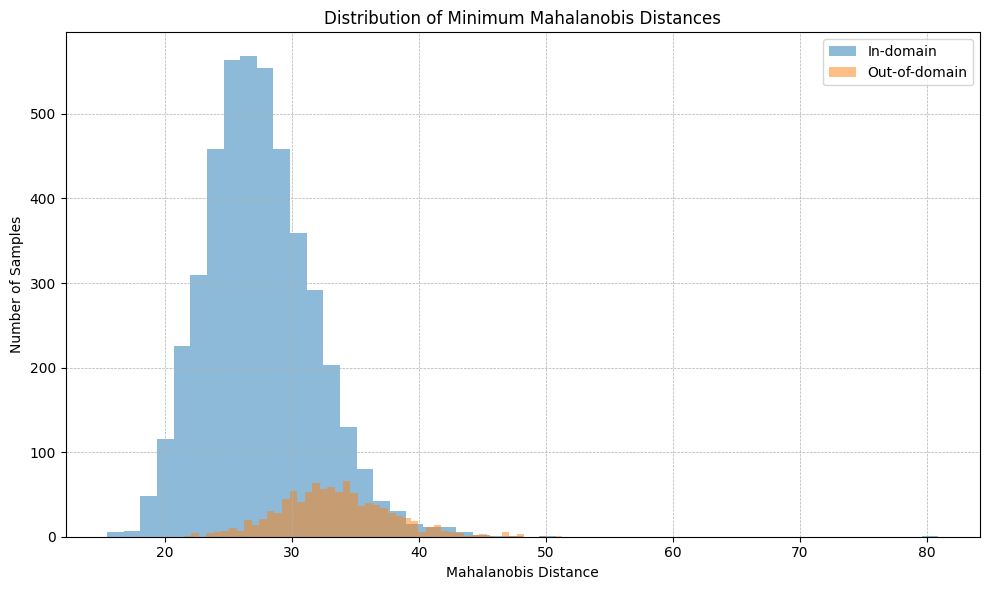

In [336]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_scores, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_scores, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Minimum Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


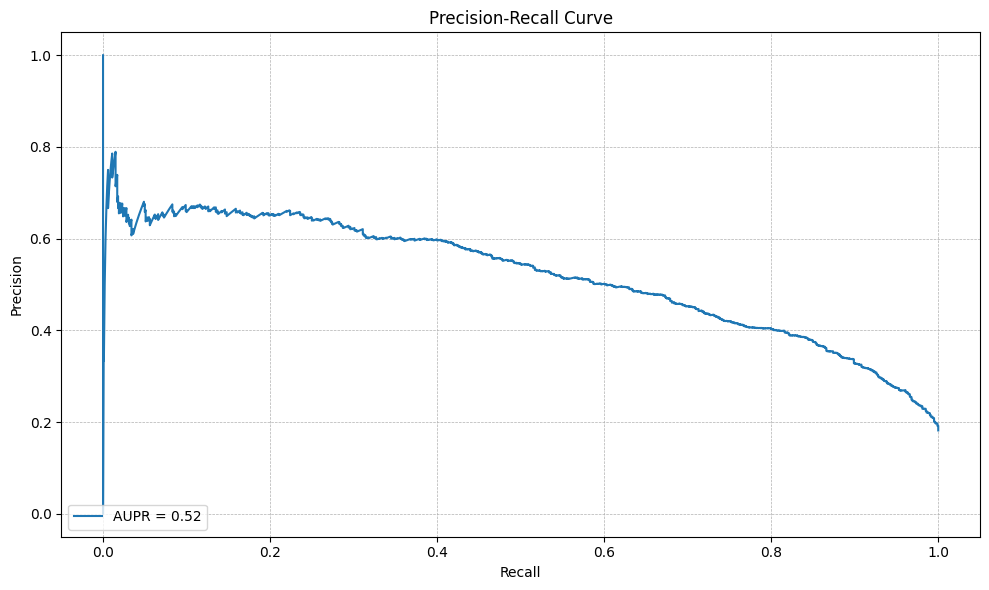

In [285]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Calculate the area under the precision-recall curve
aupr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPR = {aupr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [286]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Find the FPR where the TPR is closest to 0.95
idx = np.where(tpr >= 0.95)[0][0]
fpr_95 = fpr[idx]

fpr_95

0.5564444444444444

# KNN, K=1

In [287]:
from sklearn.neighbors import NearestNeighbors

# Initialize and fit the Nearest Neighbors model (with k=1)
knn = NearestNeighbors(n_neighbors=1)
knn.fit(train_embeddings)

NearestNeighbors(n_neighbors=1)

In [288]:
train_embeddings.shape

(15000, 768)

In [289]:
# Compute the distances to the nearest neighbors for the in-domain test set
distances_in, _ = knn.kneighbors(test_embeddings)
# Compute the distances to the nearest neighbors for the OOD test set
distances_out, _ = knn.kneighbors(oos_test_embeddings)

In [290]:
scores_in = distances_in.squeeze()
scores_out = distances_out.squeeze()

In [291]:
y_scores_knn = np.concatenate([scores_in, scores_out])

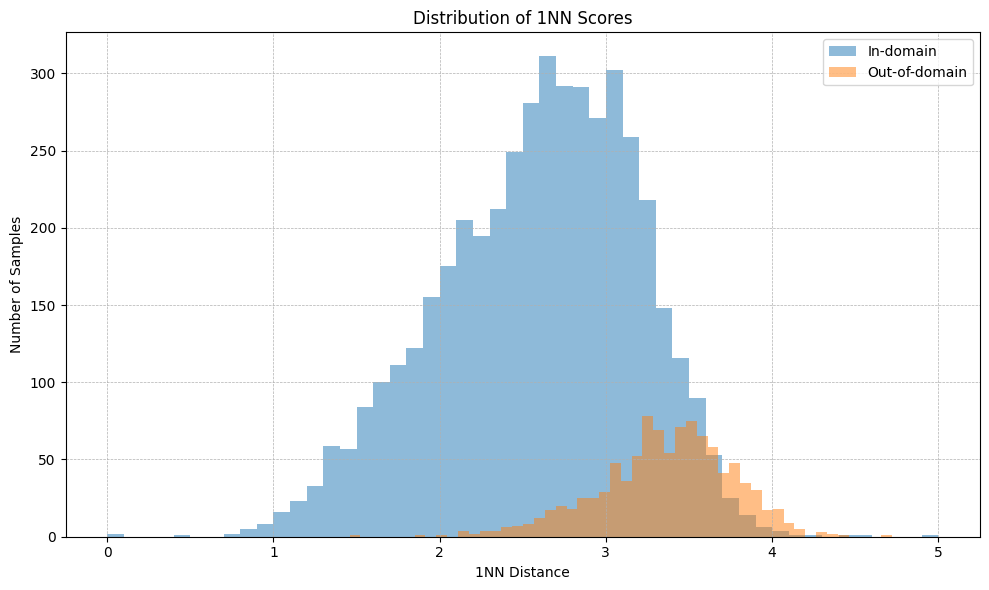

In [292]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(distances_in, bins=50, alpha=0.5, label='In-domain')
plt.hist(distances_out, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of 1NN Scores')
plt.xlabel('1NN Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [293]:
y_true_knn = [0] * len(scores_in) + [1] * len(scores_out)

In [294]:
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_true_knn, y_scores_knn)

In [296]:
aupr_knn = average_precision_score(y_true_knn, y_scores_knn)
aupr_knn


0.5894513743539356

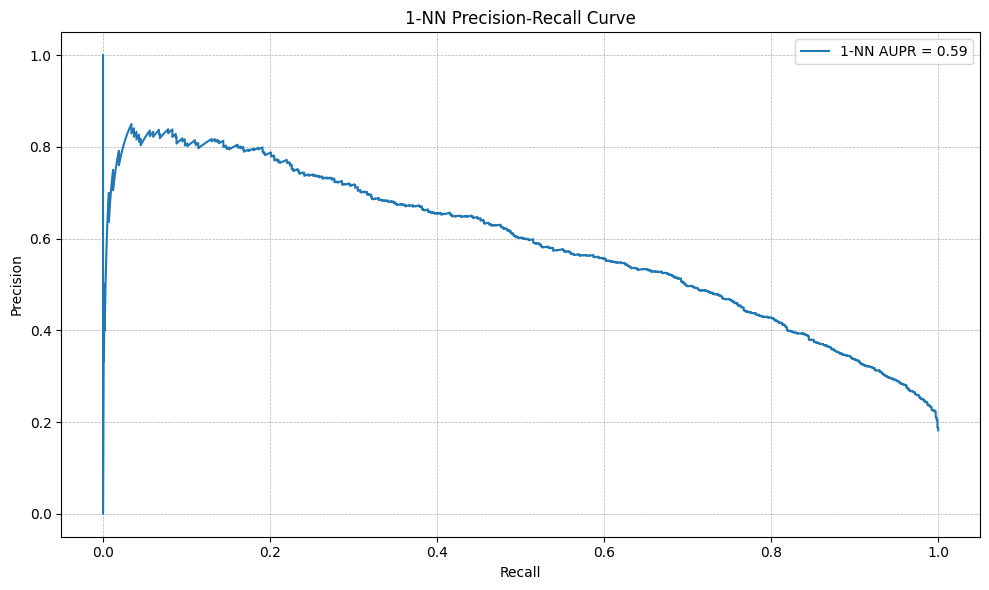

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(recall_knn, precision_knn, label=f'1-NN AUPR = {aupr_knn:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('1-NN Precision-Recall Curve')
plt.legend(loc='upper right') # Changed to 'upper right' to avoid overlap with the curve.
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [109]:
fpr, tpr, thresholds = roc_curve(y_true_knn, y_scores_knn)

# Find the FPR where the TPR is closest to 0.95
idx = np.where(tpr >= 0.95)[0][0]
fpr_95 = fpr[idx]

fpr_95

0.5113333333333333

# K-MEANS

In [110]:
from sklearn.cluster import KMeans

In [143]:
kmeans = KMeans(n_clusters=100, random_state=42).fit(train_embeddings)

/home/ztybigcat/Desktop/my_own_ood/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [144]:
test_distances_to_center = np.min(kmeans.transform(test_embeddings), axis=1)
oos_test_distances_to_center = np.min(kmeans.transform(oos_test_embeddings), axis=1)


In [147]:
y_scores_kmeans = np.concatenate([test_distances_to_center, oos_test_distances_to_center])

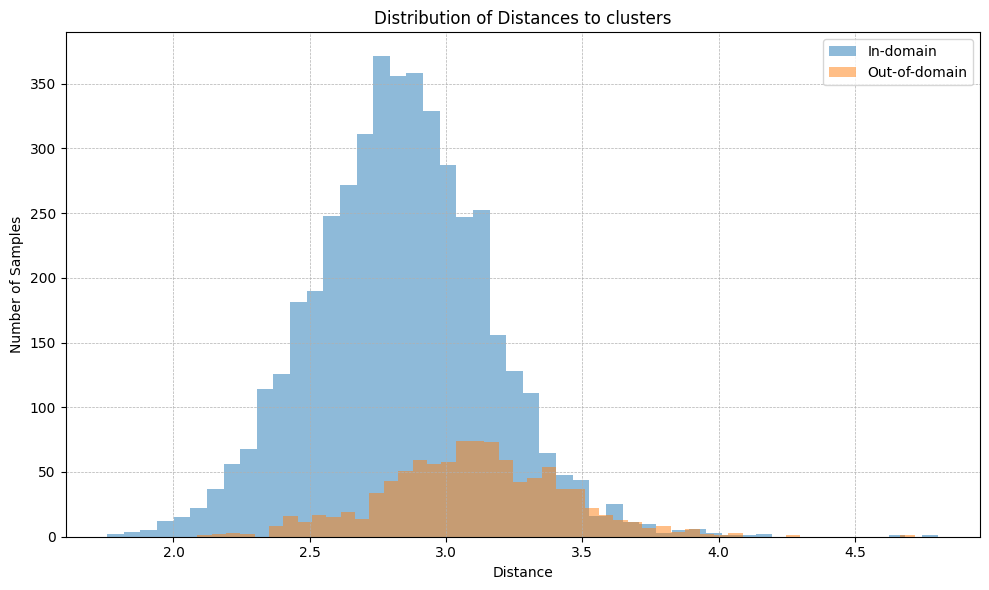

In [145]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_distances_to_center, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_distances_to_center, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Distances to clusters')
plt.xlabel('Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [152]:
precision_kmeans, recall_kmeans, thresholds_kmeans = precision_recall_curve(y_true, y_scores_kmeans)

In [153]:
precision_kmeans, recall_kmeans

(array([0.18181818, 0.18185125, 0.18188432, ..., 0.5       , 0.        ,
        1.        ]),
 array([1.   , 1.   , 1.   , ..., 0.001, 0.   , 0.   ]))

In [154]:
aupr_knn = average_precision_score(y_true, y_scores_kmeans)
aupr_knn

0.3661004389115163

# Fine tunning based on intents

In [303]:
train_sentences[:10]

['what expression would i use to say i love you if i were an italian',
 "can you tell me how to say 'i do not speak much spanish', in spanish",
 "what is the equivalent of, 'life is good' in french",
 "tell me how to say, 'it is a beautiful morning' in italian",
 'if i were mongolian, how would i say that i am a tourist',
 "how do i say 'hotel' in finnish",
 "i need you to translate the sentence, 'we will be there soon' into portuguese",
 'please tell me how to ask for a taxi in french',
 "can you tell me how i would say, 'more bread please' in french",
 "what is the correct way to say 'i am a visitor' in french"]

In [304]:
train_labels[:10]

['translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate']

In [27]:
from torch import nn, Tensor
from torch.utils.data import DataLoader
from sentence_transformers.readers import InputExample
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import losses
from typing import Union, Tuple, List, Iterable, Dict, Callable

In [16]:
label_encoder = LabelEncoder()

# Fit the label encoder and transform labels to integers
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_dev_labels = label_encoder.fit_transform(val_labels)

In [45]:
sentence_dict = {}
for label, sentence in zip(encoded_train_labels, train_sentences):
    if label in sentence_dict:
        sentence_dict[label].append(sentence)
    else:
        sentence_dict[label] = [sentence]

In [46]:
train_examples = []
# Iterate over each label
for label, sentences in sentence_dict.items():
    # Iterate over sentences two at a time
    for i in range(0, len(sentences), 2):
        # Take two sentences to form a pair
        sentence_pair = [sentences[i], sentences[i+1]]
        # Create an InputExample with this pair and the current label
        train_examples.append(InputExample(texts=sentence_pair, label=label))

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [47]:
train_loss = losses.SoftmaxLoss(model = model, sentence_embedding_dimension = model.get_sentence_embedding_dimension(),
                                num_labels = 150)

In [48]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

In [317]:
# After training, save the model and the classifier
model_save_path = 'sentence_transformer_model.pth'
classifier_save_path = 'classifier_model.pth'

# Save the sentence transformer model
torch.save(model.state_dict(), model_save_path)

# Save the classifier model
torch.save(classifier.state_dict(), classifier_save_path)

# Set the model to evaluation mode for testing
model.eval()
classifier.eval()


Linear(in_features=768, out_features=150, bias=True)

In [342]:
word_embedding_model = models.Transformer('distilroberta-base')

In [343]:
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode="max")

In [346]:
fine_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [320]:
additional_state_dict = torch.load('sentence_transformer_model.pth', map_location=torch.device('cpu'))

In [347]:
fine_model.load_state_dict(additional_state_dict, strict=False)

<All keys matched successfully>

In [348]:
oos_val_embeddings_fine = model.encode(oos_val_sentences)

In [351]:
oos_val_embeddings == oos_val_embeddings_fine

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [426]:
torch.cuda.empty_cache()